https://www.zhihu.com/question/27213170
https://www.cnblogs.com/jiangkejie/p/15855729.html
https://blog.csdn.net/shiyuzuxiaqianli/article/details/115420168

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def _c(ca, i, j, p, q):

    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = np.linalg.norm(p[i]-q[j])
    elif i > 0 and j == 0:
        ca[i, j] = max(_c(ca, i-1, 0, p, q), np.linalg.norm(p[i]-q[j]))
    elif i == 0 and j > 0:
        ca[i, j] = max(_c(ca, 0, j-1, p, q), np.linalg.norm(p[i]-q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(
            min(
                _c(ca, i-1, j, p, q),
                _c(ca, i-1, j-1, p, q),
                _c(ca, i, j-1, p, q)
            ),
            np.linalg.norm(p[i]-q[j])
            )
    else:
        ca[i, j] = float('inf')

    return ca[i, j]
def frdist(p, q):
    p = np.array(p, np.float64)
    q = np.array(q, np.float64)

    len_p = len(p)
    len_q = len(q)

    if len_p == 0 or len_q == 0:
        raise ValueError('Input curves are empty.')

    if len_p != len_q or len(p[0]) != len(q[0]):
        raise ValueError('Input curves do not have the same dimensions.')

    ca = (np.ones((len_p, len_q), dtype=np.float64) * -1)

    dist = _c(ca, len_p-1, len_q-1, p, q)
    return dist



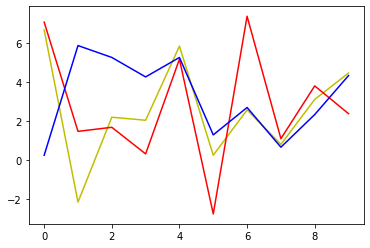

4.702951207219483
6.8124113521904075


In [2]:
np.random.seed(1)
a = np.random.normal(3, 2.5, size=(3, 10))
x = np.arange(10)
y = a[0]
y1 = a[1]
y2 = a[2]
plt.plot(x,y1,color='y')
plt.plot(x,y,color='r')
plt.plot(x,y2,color='b')
plt.show()
xy = np.vstack((x,y)).T
xy1 = np.vstack((x,y1)).T
xy2 = np.vstack((x,y2)).T
print(frdist(xy,xy1))
print(frdist(xy,xy2))

In [3]:
from tslearn.metrics import dtw
dist_ts1 = dtw(a[0], a[1])
dist_ts2 = dtw(a[0], a[2])
print(dist_ts1)
print(dist_ts2)

7.338099326229341
9.758731235061298


https://tslearn.readthedocs.io/en/stable/auto_examples/neighbors/plot_knn_search.html#sphx-glr-auto-examples-neighbors-plot-knn-search-py

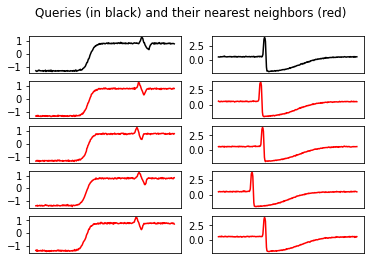

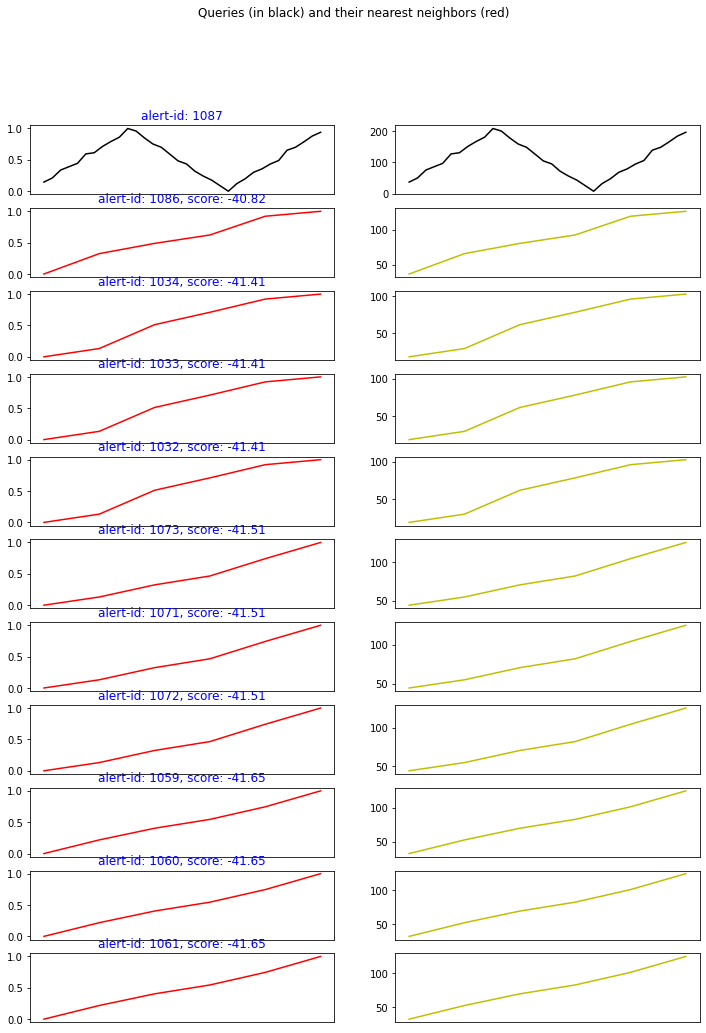

In [18]:
import numpy
import matplotlib.pyplot as plt
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
import os, requests, json
def handle_ts_data_length(data, length):
    return data[:length]
def handle_alert_data(data):
    data = data['data']
    alertInfos = data[0]['alertRelatedInfos']
    alertIdList = []
    alertTsValues = []
    alertIdI = data[0]['alertId']
    alertITs = []
    for item in alertInfos:
        alertId = item['alertId']
        tsvalue = item['sensorValue']['values']
        tsvalue = handle_ts_data_length(tsvalue, 1000)
        if (alertIdI == alertId) :
            alertITs.append(tsvalue)
        else:
            alertIdList.append(alertId)
            alertTsValues.append(tsvalue)

    return alertITs, alertIdList, alertTsValues

def get_data(alert_id):
    url = 'http://10.192.30.68/gateway/dpp-core/v2/third-party/alert/details'
    s = json.dumps({'alertIds': [alert_id]})
    r = requests.post(url, data=s, headers = {"Content-Type": "application/json"})
    return json.loads(r.text)

def transform_data(data):
    res = []
    for x in data:
        z = float(x)
        res.append(z)
    return res

alert_id = 1087
data = get_data(alert_id)
alertITs, alertIdList, alertTsValues= handle_alert_data(data)
alert_len = len(alertIdList)
n_neighbors = 10
X = to_time_series_dataset(alertTsValues)
X_train = TimeSeriesScalerMinMax().fit_transform(X)
X_test = TimeSeriesScalerMinMax().fit_transform(to_time_series_dataset(alertITs))
knn = KNeighborsTimeSeries(n_neighbors=n_neighbors,metric="dtw")
knn.fit(X_train)
ind = knn.kneighbors(X_test, return_distance=True)
#距离
# print(ind[0])
# #对应的数组下标
# print(ind[1])

plt.figure(figsize=(12, 16.5))
plt.subplot(n_neighbors + 1, 2, 1)
plt.plot(X_test.ravel(), "k-")
plt.title("alert-id: " + str(alert_id), {'color':'blue'})
plt.xticks([])

plt.subplot(n_neighbors + 1, 2, 2)
plt.plot(transform_data(alertITs[0]), "k-")
plt.xticks([])
for rank_nn in range(n_neighbors):
    plt.subplot(n_neighbors + 1, 2, rank_nn * 2 + 3 )
    paid = alertIdList[ind[1][0][rank_nn]]
    pascore = format(100 - (ind[0][0][rank_nn] * 100), '.2f')
    title = "alert-id: " + str(paid) + ", score: " + str(pascore)
    plt.plot(X_train[ind[1][0, rank_nn]].ravel(), "r-")
    plt.title(title, {'color':'blue'})
    plt.xticks([])
    
    plt.subplot(n_neighbors + 1, 2, rank_nn * 2 + 4 )
    itts = alertTsValues[ind[1][0][rank_nn]]
    plt.plot(transform_data(itts), "y-")
    plt.xticks([])


plt.suptitle("Queries (in black) and their nearest neighbors (red)")
plt.show()
#plt.savefig('1.png')
